# Using TorchServe to serve a PyTorch Object Detection model

## Dependencies

In [1]:
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

## Display image

/home/model-server/tmp/ipykernel_90/3223673323.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /home/model-server/tmp/tmp5vlj6w68.jpg.


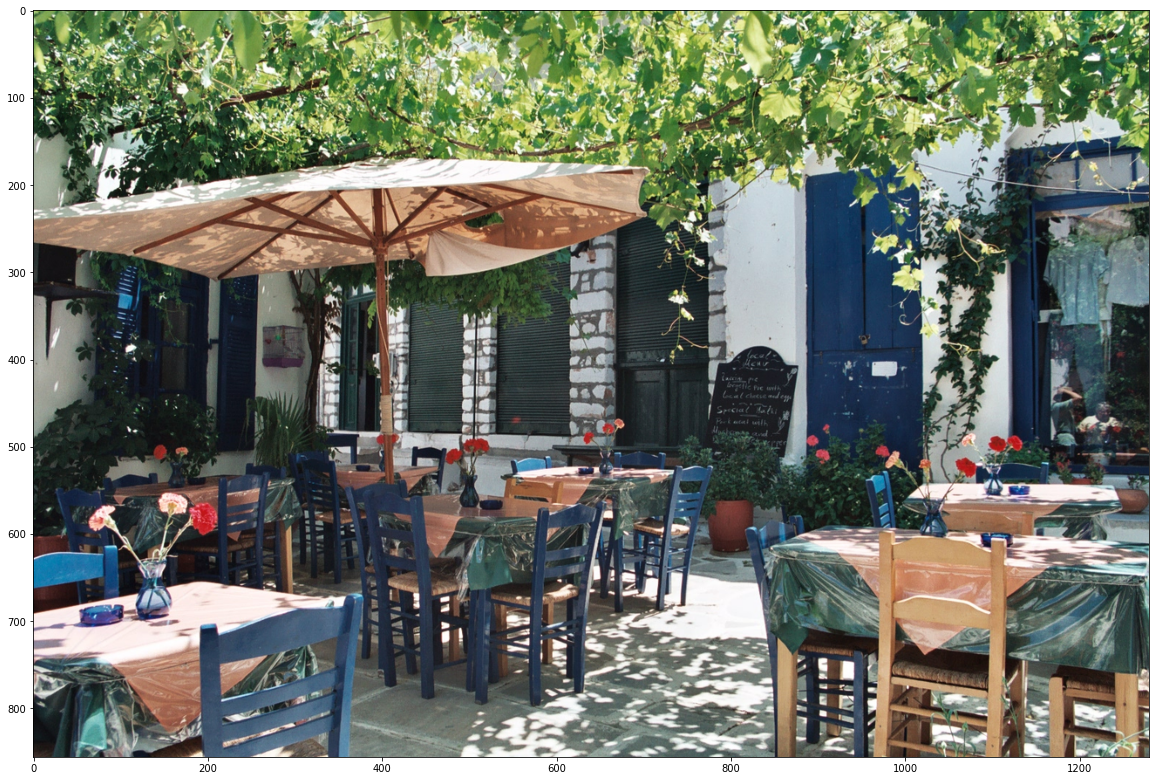

In [3]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg" 
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

## Example use

In [4]:
# Access fastrcnn by restful API
url = 'http://127.0.0.1:8080/predictions/fastrcnn'
image_path = './samples/Naxos_Taverna.jpg'

In [5]:
def make_request(url, image_path):
    img_file = open(image_path, 'rb')
    response = requests.post(url, data=img_file.read())
    return response.json()

In [6]:
detections = make_request(url, image_path)

In [12]:
print(len(detections), detections)

41 [{'chair': [444.4649963378906, 652.8606567382812, 605.0023193359375, 935.0953979492188], 'score': 0.9965025186538696}, {'chair': [810.8794555664062, 619.2907104492188, 932.3850708007812, 822.3911743164062], 'score': 0.9957947731018066}, {'chair': [626.7456665039062, 671.1788940429688, 786.2647705078125, 956.2196655273438], 'score': 0.9936059713363647}, {'vase': [143.85157775878906, 769.6183471679688, 192.13282775878906, 833.9157104492188], 'score': 0.9737146496772766}, {'chair': [355.61346435546875, 610.3934936523438, 443.4256591796875, 792.5303955078125], 'score': 0.9687244296073914}, {'vase': [586.9454345703125, 636.6525268554688, 613.4814453125, 682.5081787109375], 'score': 0.9556264877319336}, {'potted plant': [921.0094604492188, 580.652587890625, 1029.5020751953125, 747.8502197265625], 'score': 0.9553043842315674}, {'chair': [0.3294042944908142, 741.3318481445312, 104.90351104736328, 827.3018798828125], 'score': 0.9552479386329651}, {'potted plant': [291.24237060546875, 517.973

In [26]:
def load_image(image_path) :
    img = Image.open(image_path)
    img.load()
    img = np.array(img, dtype=np.uint8)
    return img

def visualize_detections(image_path, detections, figsize=(20, 15)):
    
    img = load_image(image_path)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(img)
 
    scoreArr, nameArr, boxArr = [], [], []
    
    for detection in detections:
        score = detection['score']
        name = [x for x in detection.keys() if x != 'score'][0]  #class_names
        box = detection[name] #boxes
        scoreArr.append(score)
        nameArr.append(name)
        boxArr.append(box)

    scoreArr, nameArr, boxArr = np.array(scoreArr), np.array(nameArr), np.array(boxArr)

    boxes, class_names, scores = boxArr, nameArr, scoreArr
    max_boxes, min_score = 18, 0.1
    score_split_w = 0.95  # 0.95~1.00 
    score_split_r = 0.90  #0.90~0.95 

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:  
          xmin, ymin, xmax, ymax = tuple(boxes[i])
          ax = plt.gca()
          text = "{}: {:.2f}".format(class_names[i], (scores[i]))
          w, h = xmax - xmin, ymax - ymin
          if scores[i] >= score_split_w:
              patch = plt.Rectangle(
                [xmin, ymin], w, h, fill=False, edgecolor='w', linewidth=3
            )
          else:
            patch = plt.Rectangle(
              [xmin, ymin], w, h, fill=False, edgecolor='c', linewidth=3
            )
         
        ax.add_patch(patch)
        
        if scores[i] >= score_split_w:
            ax.text(
                xmin,
                ymin,
                text,
                bbox={"facecolor": 'w', "alpha": 1.0},
                clip_box=ax.clipbox,
                clip_on=True,
            )
        else:
            ax.text(
                xmin,
                ymin,
                text,
                bbox={"facecolor": 'c', "alpha": 0.8},
                clip_box=ax.clipbox,
                clip_on=True,
            )

    plt.show()

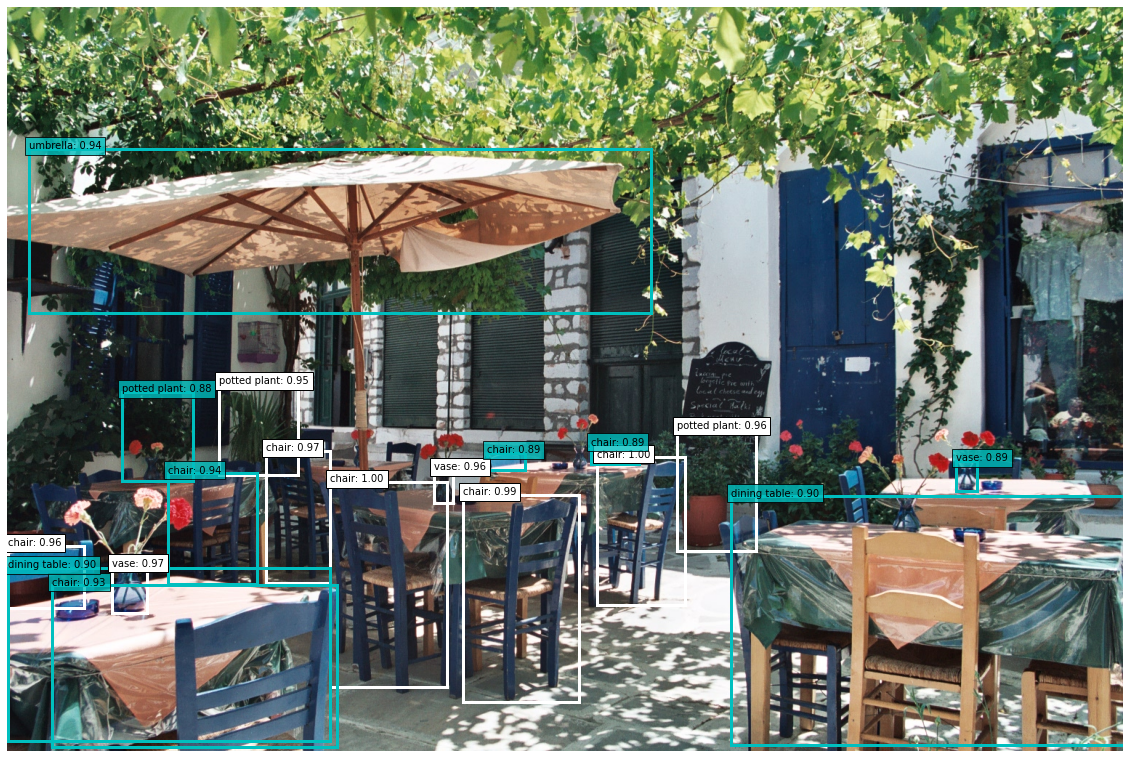

In [27]:
visualize_detections(image_path, detections)